In [18]:
!pip install numpy>=1.18.0
! pip install pandas==1.1.0
! pip install opencv-python==4.4.0.46
! pip install rasterio[s3]==1.1.8
! pip install awscli
! pip install geopandas
!pip install boto3
!pip install rasterio

zsh:1: 1.18.0 not found
zsh:1: no matches found: rasterio[s3]==1.1.8


In [19]:
import os
os.environ['AWS_NO_SIGN_REQUEST'] = 'YES'

In [20]:
import ast
import itertools
import math
from collections.abc import Iterable
from pathlib import Path
from typing import Dict
from typing import Tuple, List, Sequence
from urllib.parse import urlparse

import boto3
import botocore
import cv2
import geopandas as gpd
import numpy as np
import pandas as pd
import rasterio
import rasterio.mask
from rasterio.io import DatasetReader
from tqdm import tqdm
import matplotlib.pyplot as plt

## Utility Functions & Classes

In [21]:
def read_image(image_path: str or Path) -> np.ndarray:
    """
    Reads an image and returns it.
    Args:
        image_path: the path of the image
    Returns:
        array of image
    """
    image_path = image_path if isinstance(image_path, str) else str(image_path)
    image = cv2.imread(image_path, cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)

    if image is None:
        raise ValueError(f'Failed to read image from {image_path} path.')

    return image


In [22]:
def save_image(image: np.ndarray, image_path: str or Path, image_band: str = None) -> str:
    """
    Saves image and returns True in case of successful saving.
    Args:
        image: the image array to save
        image_path: the path of the image
        image_band: the image band name, which will be used in case of various color conversions
    Returns:
        image_path if image is successfully saved
    Raises:
        ValueError if the image is not saved
    """
    image_path = image_path if isinstance(image_path, str) else str(image_path)

    if image_band == 'RGB':
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    try:
        check = cv2.imwrite(image_path, image)
    except Exception as e:
        raise ValueError(f'Failed to save image in {image_path} path due to error:\n {e}.')
    else:
        if check:
            return image_path
        else:
            ValueError(f'Failed to save image in {image_path} path.')



In [23]:
def crop_image(image: np.ndarray, crop_area: Tuple[int, int, int, int]) -> np.ndarray:
    """
    Crops an are of image using its (top, left, bottom, right) coordinates.
    Args:
        image: 2D or 3D image, with shapes (H, W) or (H, W, C)
        crop_area: (top, left, bottom, right) coordinates of area

    Returns:
        cropped image array
    """
    top, left, bottom, right = crop_area
    if image.ndim == 2:
        return image[top:bottom, left:right]
    elif image.ndim == 3:
        return image[top:bottom, left:right, :]
    else:
        raise ValueError(f'The input image must be 2D or 3D, got: {image.shape}')


In [24]:
def resize_image(image: np.ndarray, size: Tuple[int, int], algorithm=cv2.INTER_CUBIC):
    """
    Args:
        image: the image to resize
        size: the size of the new image - (H, W)
        algorithm: the algorithm used for resizing the image

                    Possible algorithms are:
                      INTER_NEAREST      = 0 - nearest neighbor interpolation
                      INTER_LINEAR       = 1 - bilinear interpolation
                      INTER_CUBIC        = 2 - bicubic interpolation
                      INTER_AREA         = 3 - resampling using pixel area relation
                      INTER_LANCZOS4     = 4 - Lanczos interpolation over 8x8 neighborhood
                      INTER_LINEAR_EXACT = 5 - Bit exact bilinear interpolation
    Returns:
        resized image array
    """
    # if size is None or equal to current size then return the original image
    if size is None or size == image.shape[:2]:
        return image

    # openCV takes fx=W and fy=H
    resized = cv2.resize(image, tuple(reversed(size)), interpolation=algorithm)

    # openCV losses single channel images 3rd dimension
    if image.ndim == 3 and resized.ndim != 3:
        resized = np.expand_dims(resized, axis=2)

    return resized


In [25]:
class Slider:
    """Special class for sliding images, aka creatint tiles or patches."""

    def __init__(self,
                 window: int or Tuple[int, int],
                 stride: int or Tuple[int, int],
                 scales: float or Iterable[float] = (1.0,), ):
        """
        Args:
            window: int or (int, int), (h, w) the window size,
            stride: int or (int, int), (dh, dw) the strides,
            scales: (float ...), the scales to resize the original image
                    <1: downscale the original image
                    >1: upscale
        """
        if isinstance(window, int):
            self.window = (window, window)
        elif isinstance(window, tuple):
            self.window = window
        else:
            raise TypeError(f'window must be tuple or int, got {type(window)}')

        if isinstance(stride, int):
            self.stride = (stride, stride)
        elif isinstance(stride, tuple):
            self.stride = stride
        else:
            raise TypeError(f'stride must be tuple or int, got: {type(stride)}')

        if isinstance(scales, (float, int)):
            self.scales = (scales,)
        elif isinstance(scales, Iterable):
            self.scales = scales
        else:
            raise TypeError(f'scales must be iterable or float or int, got: {type(scales)}')

    def get_number_of_patches(self, input_h: int, input_w: int) -> int:
        """For given input sizes returns the possible number of sliding operations or the number of patches."""
        n_vertical = math.ceil((input_h - self.window[0]) / self.stride[0]) + 1
        n_horizontal = math.ceil((input_w - self.window[1]) / self.stride[1]) + 1
        n_scales = sum(1 for _ in self.scales)
        return n_horizontal * n_vertical * n_scales

    @staticmethod
    def apply_scale(scale: float, h: int, w: int) -> Tuple[int, int]:
        """Applies scaling."""
        return int(h / scale), int(w / scale)

    @staticmethod
    def get_1d_offset(current_position: int, step: int, original_size: int) -> Tuple[int, int]:
        """Returns the 1d offset coordinates as a result of one step from given position.
        If the potential window size exceed the original image size for instance,
        window_h > image_h, window_h will thrink to image_h. """
        if current_position == 0 and step > original_size:
            offset = (0, original_size)
        elif current_position + step > original_size:
            offset = (original_size - step, original_size)
        else:
            offset = (current_position, current_position + step)
        return offset

    def get_offsets(self, input_h: int, input_w: int) -> List[Tuple[int, int, int, int]]:
        """
        Returns the offsets: (top, left, bottom, right) to get sub-images as a result of sliding.
        Args:
            input_h: input image height
            input_w: input image width
        Returns:
            list of tuples where each tuple contains the patches or sub-images coordinates: (top, left, bottom, right)
        """
        all_offsets = []
        for s in self.scales:
            window_h, window_w = self.apply_scale(s, *self.window)
            stride_h, stride_w = self.apply_scale(s, *self.stride)
            hs = [self.get_1d_offset(h, window_h, input_h) for h in range(0, input_h - window_h + stride_h, stride_h)]
            ws = [self.get_1d_offset(w, window_w, input_w) for w in range(0, input_w - window_w + stride_w, stride_w)]
            all_offsets += list(itertools.product(hs, ws))

        return [(x[0][0], x[1][0], x[0][1], x[1][1]) for x in all_offsets]

    def get_patch(self, image: np.ndarray, offset: Tuple[int, int, int, int]):
        """
        Args:
            image: original image to extract patch, which must have the shape H x W x C
            offset: the tuples(top, left, bottom, right)
        Returns:
            image patch or sub-image window_h x window_h x C
        """
        return resize_image(crop_image(image, offset), self.window, algorithm=cv2.INTER_CUBIC)

    def get_patches(self, image: np.ndarray, offsets: List[Tuple[int, int, int, int]]):
        """
        Args:
            image: original image to extract patches, which must have the shape H x W x C
            offsets: the list of tuples (top, left, bottom, right)
        Returns:
            image patches concatenated in one array with shape: N x window_h x window_h x C,
            where N = len(offsets)
        """
        return np.stack(tuple(self.get_patch(image, offset) for offset in offsets))

    @staticmethod
    def reconstruct(patches: Sequence[np.ndarray],
                    offsets: List[Tuple[int, int, int, int]],
                    output_shape: Tuple[int, int, int] or Tuple[int, int]):
        """
        Recovers the image using its patches and their coordinates. Assumes that patches may
        overlap. Overlapped patches are averaged.
        Args:
            patches: the list of image patches
            offsets: the list of offsets (patch coordinates (top, left, bottom, right))
            output_shape: the shape of the output image (H, W, C) or (H, W)
        Returns:
            the array of output image with shape = output shape
        """

        if len(patches) != len(offsets):
            raise ValueError('Number of patches must be equal to number of offsets.')

        out_image, counter = np.zeros(output_shape), np.zeros(output_shape, dtype=np.float32)
        for offset, patch in zip(offsets, patches):
            top, left, bottom, right = offset
            out_image[top:bottom, left:right] += patch
            counter[top:bottom, left:right] += 1.

        out_image /= counter
        return out_image



## Data Download

In [26]:

class FlightObject:
    """Special class for preparing data using flight id and field id."""

    BANDS = ('rgb', 'mask')

    def __init__(self, flight_id: str, field_id: str, download_folder: str):
        """

        Args:
            flight_id: the unique id of the flight
            field_id: the unique id of the field
            download_folder: the folder path where the flight data is downloaded
        """
        paths = self.get_image_paths_from_flight_code(flight_id, download_folder)
        self._download_folder = download_folder
        self._border_file_path = paths.pop('border_file_path')
        self._image_paths = {k.replace('_path', ''): v for k, v in paths.items()}

        self._flight_id = flight_id
        self._field_id = field_id
        self._output_depth = 'uint16'

        self._base_name = f"{self._field_id}_{self._flight_id}"
        self._crop_coordinates = None
        self._mask = None

    @staticmethod
    def get_image_paths_from_flight_code(flight_code: str, download_folder: str) -> Dict[str, str]:
        """Returns r, g, b and boarder file paths based on flight code."""
        return {
            'red_path': f'{download_folder}/{flight_code}/reflectance_red-red.tif',
            'green_path': f'{download_folder}/{flight_code}/reflectance_green-green.tif',
            'blue_path': f'{download_folder}/{flight_code}/reflectance_blue-blue.tif',
            'border_file_path': f'{download_folder}/{flight_code}/boundary.zip'
        }

    @property
    def image_paths(self) -> Dict[str, str]:
        """Returns images paths in S3."""
        return self._image_paths.copy()

    @property
    def border_file_path(self) -> str:
        """Returns images paths in S3."""
        return self._border_file_path

    @staticmethod
    def read_single_channel_raster_image(image_path: str,
                                         get_dataset: bool, ) -> np.ndarray or Tuple[np.ndarray, DatasetReader]:
        """Reads single channel raster image"""
        with rasterio.open(image_path) as src:
            image = np.nan_to_num(np.squeeze(src.read()), nan=0, posinf=0, neginf=0).astype(np.uint16)
        return (image, src) if get_dataset else image

    @staticmethod
    def get_border_mask(border_file_path, raster_dataset: DatasetReader) -> np.ndarray:
        """Returns boolean mask, where True means that pixel belongs to the field, aka inside the border geometry."""
        gdf = gpd.read_file(border_file_path)
        if gdf.shape[0] != 1 or 'geometry' not in gdf.columns:
            raise ValueError(f'Boundary file {border_file_path} is wrong.')

        border_geometry = gdf.to_crs(crs=raster_dataset.crs)['geometry'].iloc[0]
        mask, _, _ = rasterio.mask.raster_geometry_mask(raster_dataset, [border_geometry], crop=False, invert=True)
        return mask

    def get_mask(self) -> np.ndarray:
        """Returns boolean Border Mask."""
        red_image, red_raster_dataset = self.read_single_channel_raster_image(
            self._image_paths['red'], True
        )

        border_mask = self.get_border_mask(self._border_file_path, red_raster_dataset)
        border_mask = np.nan_to_num(border_mask, nan=0, posinf=0, neginf=0)

        x_index, y_index = np.nonzero(border_mask)
        self._crop_coordinates = (x_index.min(), y_index.min(), x_index.max(), y_index.max())
        self._mask = crop_image(border_mask, self._crop_coordinates).astype(np.uint8)

        return self._mask.copy()

    def get_rgb(self) -> np.ndarray:
        """Returns RGB image as uint8 or unit16."""
        rgb_image = np.stack(
            [
                self.read_single_channel_raster_image(self._image_paths[c], False)
                for c in ('red', 'green', 'blue')
            ],
            axis=2
        )
        return crop_image(rgb_image, self._crop_coordinates)

    def get_images(self) -> Dict[str, np.ndarray]:
        """Returns all images."""
        mask = self.get_mask()
        rgb = self.get_rgb()
        rgb *= mask[..., np.newaxis]
        return {'rgb': rgb, 'mask': mask}

    def create_tiles(self, output_folder: Path, slider_config: Dict) -> List[str]:
        """
        Scales images by given scale factor, creates patches and saves them in output folder.
        Args:
            output_folder: the folder where the patched images will be saved
            slider_config: the config creating patches (tiles)
        """
        factor = 2**14
        rgb = self.get_images()['rgb']
        rgb = np.clip((rgb / factor) * 255,0, 255)
        slider = Slider(**slider_config)
        offsets = slider.get_offsets(*rgb.shape[:2])

        tile_paths = []
        for i, offset in enumerate(offsets):
            tile = slider.get_patch(rgb, offset)
            band_image_name = f'{self._base_name}_rgb_{i}-patch.png'
            check = np.all(tile == 0)
            if check:
                print(f'{self._flight_id}-{self._field_id}: patch_number={i} have been skipped.')
            else:
                output_path = output_folder.joinpath(band_image_name)
                output_path.parent.mkdir(exist_ok=True, parents=True)
                tile_paths.append(save_image(tile, output_path, image_band='rgb'))
        print(f'{self._base_name}: n={len(tile_paths)} patches have been saved, original size={rgb.shape}.')
        return tile_paths


In [27]:
class DatasetCreator:
    """Special Class for downloading images from S3 and splitting them into small tiles."""

    def __init__(self, s3_uri: str, download_folder: str, output_folder: str, tile_size: int = 512):
        """

        Args:
            s3_uri: the  S3 URI - path of the images in S3
            download_folder: the folder to store raw images
            output_folder: the folder to store tiles (aka, small images with equal sizes)
            tile_size: the size of tiles, default: 512
        """

        self.download_folder = Path(download_folder)
        self.output_folder = Path(output_folder)

        self.download_folder.mkdir(parents=True, exist_ok=True)
        self.output_folder.mkdir(parents=True, exist_ok=True)

        parsed_uri = urlparse(s3_uri, allow_fragments=False)
        self.s3_uri = s3_uri
        self.s3_bucket = parsed_uri.netloc
        self.s3_folder = parsed_uri.path.lstrip('/')

        self.tile_size = tile_size

    @staticmethod
    def download_s3_dir(bucket: str, folder_path: str, download_folder: Path):
        """Downloads s3 directory to download folder."""
        client = boto3.client('s3')
        client.meta.events.register('choose-signer.s3.*', botocore.handlers.disable_signing)

        # Handle missing / at end of prefix
        if not folder_path.endswith('/'):
            folder_path += '/'

        paginator = client.get_paginator('list_objects_v2')
        for result in paginator.paginate(Bucket=bucket, Prefix=folder_path):
            # Download each file individually
            for key in tqdm(result['Contents'], total=len(result['Contents'])):
                # Calculate relative path
                rel_path = key['Key'][len(folder_path):]
                # Skip paths ending in /
                if not key['Key'].endswith('/'):
                    local_file_path = download_folder.joinpath(rel_path)
                    local_file_path.parents[0].mkdir(parents=True, exist_ok=True)
                    # Skip download if already downloaded
                    if not local_file_path.exists():
                        client.download_file(bucket, key['Key'], str(local_file_path))

    def download_data(self):
        """Downloads data from S3."""
        self.download_s3_dir(self.s3_bucket, self.s3_folder, self.download_folder)
        df = pd.read_csv(self.download_folder.joinpath('final_data.CSV'))
        df['paths'] = df['paths'].apply(ast.literal_eval)
        df['local_paths'] = df['paths'].apply(
            lambda x: {k: v.replace(self.s3_uri, str(self.download_folder)) for k, v in x.items()}
        )
        return df

    def create_tiles(self, df: pd.DataFrame) -> pd.DataFrame:
        """Creates tiles from downloaded images."""
        slider_config = {'window': self.tile_size, 'stride': self.tile_size, 'scales': (1,)}

        final_df = []
        for _, row in tqdm(df.iterrows(), total=len(df)):
            flight_obj = FlightObject(row['flight_code'], row['field_token'], self.download_folder)
            tiles_paths = flight_obj.create_tiles(self.output_folder, slider_config)
            for i, tile_path in enumerate(tiles_paths):
                final_df.append(
                    {
                        'flight_code': row['flight_code'],
                        'field_token': row['field_token'],
                        'class': row['ActualStatus'],
                        'flight_date': row['flight_date'],
                        'flight_number': row['flight_number'],
                        'tile_number': i,
                        'image_path': tile_path,
                    }
                )
        final_df = pd.DataFrame(final_df)
        final_df['class'] = final_df['class'].isin(('Planted', 'Emerged'))

        return final_df

    def prepare_data(self):
        """Downloads data, creates tiles and saves them in output folder."""
        df = self.download_data()
        tiles_df = self.create_tiles(df)
        tiles_df.to_csv(self.output_folder.joinpath('tiles.CSV'), index=False)
        return tiles_df


In [143]:
S3_URI = 's3://intelinair-internship/field_state_classification/'
DOWNLOAD_FOLDER = 'anna/image_data'
OUTPUT_FOLDER = 'anna/final_image_data'
TILE_SIZE = 512

In [144]:
creator = DatasetCreator(S3_URI, DOWNLOAD_FOLDER, OUTPUT_FOLDER, tile_size=512)

In [145]:
df = creator.prepare_data()

  3%|▎         | 1/30 [00:06<02:55,  6.06s/it]

b7add13d-8802-46cb-8d3f-cb1ce7daf029_1TJZT39WQ: n=64 patches have been saved, original size=(3999, 4016, 3).


  7%|▋         | 2/30 [00:17<03:34,  7.65s/it]

2HHWV1DD4-7e227290-9936-483e-90de-949c80f984d7: patch_number=116 have been skipped.
2HHWV1DD4-7e227290-9936-483e-90de-949c80f984d7: patch_number=117 have been skipped.
2HHWV1DD4-7e227290-9936-483e-90de-949c80f984d7: patch_number=118 have been skipped.
2HHWV1DD4-7e227290-9936-483e-90de-949c80f984d7: patch_number=119 have been skipped.
7e227290-9936-483e-90de-949c80f984d7_2HHWV1DD4: n=116 patches have been saved, original size=(10086, 2669, 3).


 10%|█         | 3/30 [00:23<03:15,  7.25s/it]

3KR1212BR-7e227290-9936-483e-90de-949c80f984d7: patch_number=77 have been skipped.
3KR1212BR-7e227290-9936-483e-90de-949c80f984d7: patch_number=78 have been skipped.
3KR1212BR-7e227290-9936-483e-90de-949c80f984d7: patch_number=79 have been skipped.
7e227290-9936-483e-90de-949c80f984d7_3KR1212BR: n=77 patches have been saved, original size=(7980, 2116, 3).


 13%|█▎        | 4/30 [00:29<02:58,  6.88s/it]

42T73AQE8-7e227290-9936-483e-90de-949c80f984d7: patch_number=77 have been skipped.
42T73AQE8-7e227290-9936-483e-90de-949c80f984d7: patch_number=78 have been skipped.
42T73AQE8-7e227290-9936-483e-90de-949c80f984d7: patch_number=79 have been skipped.
7e227290-9936-483e-90de-949c80f984d7_42T73AQE8: n=77 patches have been saved, original size=(7980, 2116, 3).
E83UE8JT4-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=0 have been skipped.
E83UE8JT4-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=8 have been skipped.


 17%|█▋        | 5/30 [00:36<02:52,  6.89s/it]

E83UE8JT4-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=81 have been skipped.
b7add13d-8802-46cb-8d3f-cb1ce7daf029_E83UE8JT4: n=87 patches have been saved, original size=(4708, 4541, 3).


 20%|██        | 6/30 [00:42<02:39,  6.64s/it]

EB4KG2F6D-7e227290-9936-483e-90de-949c80f984d7: patch_number=77 have been skipped.
EB4KG2F6D-7e227290-9936-483e-90de-949c80f984d7: patch_number=78 have been skipped.
EB4KG2F6D-7e227290-9936-483e-90de-949c80f984d7: patch_number=79 have been skipped.
7e227290-9936-483e-90de-949c80f984d7_EB4KG2F6D: n=77 patches have been saved, original size=(7980, 2116, 3).


 23%|██▎       | 7/30 [00:48<02:28,  6.47s/it]

b7add13d-8802-46cb-8d3f-cb1ce7daf029_EVTQTDFEJ: n=81 patches have been saved, original size=(4451, 4291, 3).


 27%|██▋       | 8/30 [00:53<02:13,  6.05s/it]

b7add13d-8802-46cb-8d3f-cb1ce7daf029_F98U2YA3K: n=64 patches have been saved, original size=(3999, 4016, 3).


 30%|███       | 9/30 [00:59<02:01,  5.77s/it]

b7add13d-8802-46cb-8d3f-cb1ce7daf029_FPG2L7UTK: n=64 patches have been saved, original size=(3999, 4016, 3).


 33%|███▎      | 10/30 [01:04<01:56,  5.82s/it]

FVI8IQG1F-7e227290-9936-483e-90de-949c80f984d7: patch_number=77 have been skipped.
FVI8IQG1F-7e227290-9936-483e-90de-949c80f984d7: patch_number=78 have been skipped.
FVI8IQG1F-7e227290-9936-483e-90de-949c80f984d7: patch_number=79 have been skipped.
7e227290-9936-483e-90de-949c80f984d7_FVI8IQG1F: n=77 patches have been saved, original size=(7980, 2116, 3).


 37%|███▋      | 11/30 [01:10<01:46,  5.60s/it]

b7add13d-8802-46cb-8d3f-cb1ce7daf029_FYXD9U983: n=64 patches have been saved, original size=(3999, 4016, 3).


 40%|████      | 12/30 [01:19<01:59,  6.67s/it]

GP3VC3W6C-7e227290-9936-483e-90de-949c80f984d7: patch_number=116 have been skipped.
GP3VC3W6C-7e227290-9936-483e-90de-949c80f984d7: patch_number=117 have been skipped.
GP3VC3W6C-7e227290-9936-483e-90de-949c80f984d7: patch_number=118 have been skipped.
GP3VC3W6C-7e227290-9936-483e-90de-949c80f984d7: patch_number=119 have been skipped.
7e227290-9936-483e-90de-949c80f984d7_GP3VC3W6C: n=116 patches have been saved, original size=(9896, 2620, 3).


 43%|████▎     | 13/30 [01:25<01:49,  6.46s/it]

GU8YLRNEP-7e227290-9936-483e-90de-949c80f984d7: patch_number=77 have been skipped.
GU8YLRNEP-7e227290-9936-483e-90de-949c80f984d7: patch_number=78 have been skipped.
GU8YLRNEP-7e227290-9936-483e-90de-949c80f984d7: patch_number=79 have been skipped.
7e227290-9936-483e-90de-949c80f984d7_GU8YLRNEP: n=77 patches have been saved, original size=(7980, 2116, 3).


 47%|████▋     | 14/30 [01:30<01:38,  6.15s/it]

b7add13d-8802-46cb-8d3f-cb1ce7daf029_GWWIAV2VV: n=64 patches have been saved, original size=(3999, 4016, 3).


 50%|█████     | 15/30 [01:36<01:32,  6.15s/it]

J926FMUHU-7e227290-9936-483e-90de-949c80f984d7: patch_number=77 have been skipped.
J926FMUHU-7e227290-9936-483e-90de-949c80f984d7: patch_number=78 have been skipped.
J926FMUHU-7e227290-9936-483e-90de-949c80f984d7: patch_number=79 have been skipped.
7e227290-9936-483e-90de-949c80f984d7_J926FMUHU: n=77 patches have been saved, original size=(7980, 2116, 3).


 53%|█████▎    | 16/30 [01:42<01:25,  6.11s/it]

KQNQBAHEH-7e227290-9936-483e-90de-949c80f984d7: patch_number=77 have been skipped.
KQNQBAHEH-7e227290-9936-483e-90de-949c80f984d7: patch_number=78 have been skipped.
KQNQBAHEH-7e227290-9936-483e-90de-949c80f984d7: patch_number=79 have been skipped.
7e227290-9936-483e-90de-949c80f984d7_KQNQBAHEH: n=77 patches have been saved, original size=(7980, 2116, 3).


 57%|█████▋    | 17/30 [01:47<01:15,  5.83s/it]

b7add13d-8802-46cb-8d3f-cb1ce7daf029_KR4TV4KAT: n=64 patches have been saved, original size=(3999, 4016, 3).


 60%|██████    | 18/30 [01:52<01:06,  5.55s/it]

M1UED3JAF-7e227290-9936-483e-90de-949c80f984d7: patch_number=77 have been skipped.
M1UED3JAF-7e227290-9936-483e-90de-949c80f984d7: patch_number=78 have been skipped.
M1UED3JAF-7e227290-9936-483e-90de-949c80f984d7: patch_number=79 have been skipped.
7e227290-9936-483e-90de-949c80f984d7_M1UED3JAF: n=77 patches have been saved, original size=(7980, 2116, 3).


 63%|██████▎   | 19/30 [01:58<00:59,  5.44s/it]

b7add13d-8802-46cb-8d3f-cb1ce7daf029_N7W26YIGK: n=64 patches have been saved, original size=(3999, 4016, 3).


 67%|██████▋   | 20/30 [02:02<00:52,  5.29s/it]

b7add13d-8802-46cb-8d3f-cb1ce7daf029_N9WCYFDNV: n=64 patches have been saved, original size=(3999, 4016, 3).


 70%|███████   | 21/30 [02:09<00:51,  5.73s/it]

NRI4TEP79-7e227290-9936-483e-90de-949c80f984d7: patch_number=77 have been skipped.
NRI4TEP79-7e227290-9936-483e-90de-949c80f984d7: patch_number=78 have been skipped.
NRI4TEP79-7e227290-9936-483e-90de-949c80f984d7: patch_number=79 have been skipped.
7e227290-9936-483e-90de-949c80f984d7_NRI4TEP79: n=77 patches have been saved, original size=(7980, 2116, 3).


 73%|███████▎  | 22/30 [02:16<00:47,  5.92s/it]

P1VA9VFEP-7e227290-9936-483e-90de-949c80f984d7: patch_number=77 have been skipped.
P1VA9VFEP-7e227290-9936-483e-90de-949c80f984d7: patch_number=78 have been skipped.
P1VA9VFEP-7e227290-9936-483e-90de-949c80f984d7: patch_number=79 have been skipped.
7e227290-9936-483e-90de-949c80f984d7_P1VA9VFEP: n=77 patches have been saved, original size=(7980, 2116, 3).


 77%|███████▋  | 23/30 [02:21<00:39,  5.70s/it]

b7add13d-8802-46cb-8d3f-cb1ce7daf029_Q9ALKK7XZ: n=64 patches have been saved, original size=(3999, 4016, 3).


 80%|████████  | 24/30 [02:26<00:33,  5.56s/it]

b7add13d-8802-46cb-8d3f-cb1ce7daf029_UI4P3E22W: n=64 patches have been saved, original size=(3999, 4016, 3).


 83%|████████▎ | 25/30 [02:32<00:28,  5.68s/it]

VQY9V2E1Q-7e227290-9936-483e-90de-949c80f984d7: patch_number=77 have been skipped.
VQY9V2E1Q-7e227290-9936-483e-90de-949c80f984d7: patch_number=78 have been skipped.
VQY9V2E1Q-7e227290-9936-483e-90de-949c80f984d7: patch_number=79 have been skipped.
7e227290-9936-483e-90de-949c80f984d7_VQY9V2E1Q: n=77 patches have been saved, original size=(7980, 2116, 3).


 87%|████████▋ | 26/30 [02:38<00:23,  5.81s/it]

VWYBY2FQY-7e227290-9936-483e-90de-949c80f984d7: patch_number=77 have been skipped.
VWYBY2FQY-7e227290-9936-483e-90de-949c80f984d7: patch_number=78 have been skipped.
VWYBY2FQY-7e227290-9936-483e-90de-949c80f984d7: patch_number=79 have been skipped.
7e227290-9936-483e-90de-949c80f984d7_VWYBY2FQY: n=77 patches have been saved, original size=(7980, 2116, 3).
W7AADUXTW-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=0 have been skipped.
W7AADUXTW-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=8 have been skipped.


 90%|█████████ | 27/30 [02:46<00:18,  6.30s/it]

W7AADUXTW-b7add13d-8802-46cb-8d3f-cb1ce7daf029: patch_number=81 have been skipped.
b7add13d-8802-46cb-8d3f-cb1ce7daf029_W7AADUXTW: n=87 patches have been saved, original size=(4708, 4541, 3).


 93%|█████████▎| 28/30 [02:51<00:11,  5.96s/it]

b7add13d-8802-46cb-8d3f-cb1ce7daf029_YLTE7FRJW: n=64 patches have been saved, original size=(3999, 4016, 3).


 97%|█████████▋| 29/30 [02:56<00:05,  5.70s/it]

b7add13d-8802-46cb-8d3f-cb1ce7daf029_ZVDH6FY93: n=64 patches have been saved, original size=(3999, 4016, 3).


100%|██████████| 30/30 [03:02<00:00,  6.07s/it]

ZVFAN11AI-7e227290-9936-483e-90de-949c80f984d7: patch_number=77 have been skipped.
ZVFAN11AI-7e227290-9936-483e-90de-949c80f984d7: patch_number=78 have been skipped.
ZVFAN11AI-7e227290-9936-483e-90de-949c80f984d7: patch_number=79 have been skipped.
7e227290-9936-483e-90de-949c80f984d7_ZVFAN11AI: n=77 patches have been saved, original size=(7980, 2116, 3).


In [146]:
df.to_csv('anna/image_data_512.csv')

In [147]:
df.head()

,flight_code,field_token,class,flight_date,flight_number,tile_number,image_path
0,1TJZT39WQ,b7add13d-8802-46cb-8d3f-cb1ce7daf029,False,2020-07-11,9,0,anna/final_image_data/b7add13d-8802-46cb-8d3f-...
1,1TJZT39WQ,b7add13d-8802-46cb-8d3f-cb1ce7daf029,False,2020-07-11,9,1,anna/final_image_data/b7add13d-8802-46cb-8d3f-...
2,1TJZT39WQ,b7add13d-8802-46cb-8d3f-cb1ce7daf029,False,2020-07-11,9,2,anna/final_image_data/b7add13d-8802-46cb-8d3f-...
3,1TJZT39WQ,b7add13d-8802-46cb-8d3f-cb1ce7daf029,False,2020-07-11,9,3,anna/final_image_data/b7add13d-8802-46cb-8d3f-...
4,1TJZT39WQ,b7add13d-8802-46cb-8d3f-cb1ce7daf029,False,2020-07-11,9,4,anna/final_image_data/b7add13d-8802-46cb-8d3f-...


In [148]:
df.shape

(2256, 7)

In [40]:
import pandas as pd
df=pd.read_csv("anna/image_data_448.csv")

In [ ]:
# from sklearn.utils import shuffle
# flight_codes=list(set(df.flight_code))
# flight_codes=shuffle(flight_codes, random_state=42)
# train_ids = flight_codes[:20]
# val_ids = flight_codes[20:25]
# test_ids = flight_codes[25:]
# train_data=df[df['flight_code'].isin(train_ids)]
# val_data=df[df['flight_code'].isin(val_ids)]
# test_data=df[df['flight_code'].isin(test_ids)]


In [ ]:
# from sklearn.model_selection import train_test_split
# train_data, test_data, _, _,= train_test_split(df, df, test_size=0.15, random_state=42, shuffle=True)
# train_data, val_data, _, _,= train_test_split(train_data, train_data, test_size=0.15, random_state=42, shuffle=True)


In [224]:
from sklearn.utils import shuffle
false_ids = list(set(df[df['class'] == False]['flight_code']))
false_ids = shuffle(false_ids, random_state=123)
train_ids=false_ids[:13]
val_ids=false_ids[13:16]
test_ids=false_ids[16:]
true_ids = list(set(df[df['class'] == True]['flight_code']))
true_ids = shuffle(true_ids,random_state=123)
train_ids = train_ids + true_ids[:7]
val_ids= val_ids+true_ids[7:9]
test_ids=test_ids + true_ids[9:]
train_data=df[df['flight_code'].isin(train_ids)]
val_data=df[df['flight_code'].isin(val_ids)]
test_data=df[df['flight_code'].isin(test_ids)]

In [225]:
# false_ids, true_ids

In [226]:
print({'train_data' : len(train_data),  
       'val_data' :   len(val_data),
       'test_data' : len(test_data)})

{'train_data': 1499, 'val_data': 359, 'test_data': 398}


In [227]:

print({'train_classes' : train_data['class'].mean()})
print({'val_classes' : val_data['class'].mean()})
print({'test_classes' : test_data['class'].mean()})

{'train_classes': 0.3775850567044696}
{'val_classes': 0.39275766016713093}
{'test_classes': 0.3542713567839196}


In [228]:
# equal observation for  two classes
train_data1=train_data[train_data['class']==True] 
train_data2=train_data[train_data['class']==False].iloc[:train_data1.shape[0],:]
train_data=pd.concat((train_data1, train_data2))

In [229]:
train_data.shape

(1132, 7)

In [230]:
!pip install torch
!pip install torchvision

In [231]:
import torch
import torch.nn as nn
from torchvision import models
import torchvision.transforms as transforms
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
from torch.utils.data import DataLoader

In [232]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [233]:
print(device)

cpu


In [234]:
class CoustomDataset:
  def __init__(self, data, transform=None):
    self.data=data
    self.transform=transform

  def __len__(self):
    return len(self.data)

  def __getitems__(self):
    from PIL import Image
    from matplotlib import cm
    images= torch.zeros(len(self.data), 3, image_height, image_width)
    labels=[]
    for idx in range(len(self.data)):
      
      sample_image = Image.fromarray(read_image(self.data['image_path'].iloc[idx]))
      sample_label = self.data['class'].iloc[idx]
      if self.transform:
        sample_image=self.transform(sample_image)
      images[idx] = sample_image
      labels.append(int(sample_label))
    labels=np.array(labels)
    labels=torch.tensor(labels)

    return (images, labels)


In [235]:
# mean=[]
# std=[]
# for i in range(3):
#   mean.append(image[:, i, :, :].mean())
#   std.append(image[:, i, :, :].std())

In [236]:
# mean, std

In [237]:
image_height=224
image_width=224
train_set=CoustomDataset(train_data, transforms.Compose([
                                                         transforms.RandomRotation(90),
                                                         transforms.RandomHorizontalFlip(),
                                                         transforms.Resize((224,224)),
                                                         transforms.ToTensor(),
                                                        #  transforms.Normalize([0.2356,0.1987,0.1784], [0.0894,0.0733,0.0642]),
]))

In [238]:
val_set=CoustomDataset(val_data, transforms.Compose([
                                                        #  transforms.RandomRotation(30),
                                                        #  transforms.RandomHorizontalFlip(),
                                                         transforms.Resize((224,224)),
                                                         transforms.ToTensor(),
                                                        #  transforms.Normalize([0.2356,0.1987,0.1784], [0.0894,0.0733,0.0642]),
]))

In [239]:
train_data = train_set.__getitems__()

In [240]:
val_data = val_set.__getitems__()

In [241]:
train_data[0].shape,  train_data[1].shape

(torch.Size([1132, 3, 224, 224]), torch.Size([1132]))

In [242]:
train_data[0].min(), train_data[0].max()

(tensor(0.), tensor(1.))

In [243]:
def collate_fn(data):
    img, bbox = data
    zipped = (img, bbox)
    return list(zipped)

In [244]:
# def my_collate(batch):
#     data = [item[0] for item in batch]
#     target = [item[1] for item in batch]
#     return [data, target]

In [245]:
train_data[0].shape, train_data[1].shape

(torch.Size([1132, 3, 224, 224]), torch.Size([1132]))

In [246]:
train_loader=DataLoader(train_data, batch_size=32, shuffle=True, collate_fn=collate_fn)

In [247]:
val_loader=DataLoader(val_data, batch_size=32, shuffle=True, collate_fn=collate_fn)

In [252]:
batch=next(iter(train_loader))
image, label = batch

In [253]:
label.shape, image.shape

(torch.Size([1132]), torch.Size([1132, 3, 224, 224]))

In [256]:
batch_val=next(iter(val_loader))
label_val, image_val = batch_val

In [257]:
image_val.shape, label_val.shape

(torch.Size([359, 3, 224, 224]), torch.Size([359]))

In [258]:
model=models.vgg13(pretrained=True)

In [259]:
model=model.to(device)

In [260]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): 

In [261]:
for parameter in model.features.parameters():
    parameter.requires_grad=False

In [262]:
model.features.parameters

<bound method Module.parameters of Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (16): ReLU(inplace=True)

In [263]:
# from  collections import OrderedDict
# model.classifier = nn.Sequential(OrderedDict([('fc1', nn.Linear(25058, 5000)),
#                                               ('relu', nn.ReLU()),
#                                               ('drop', nn.Dropout(p=0.5)),
#                                               ('fc2', nn.Linear(5000, 512)),
#                                               ('drop', nn.Dropout(p=0.5)),
#                                               ('output', nn.LogSigmoid())]))

In [264]:
model.classifier=nn.Sequential(
                              #  nn.Linear(25088,512),
                              #  nn.ReLU(),
                              #  nn.Dropout(p=0.5),
                               nn.Linear(25088,2),
                               nn.Softmax())


In [265]:
# criterion=nn.CrossEntropyLoss()
# optimizer=Adam(model.classifier.parameters(), lr=0.0001)


In [ ]:
optimizer=torch.optim.SGD(model.classifier.parameters(), lr=0.001)

In [266]:
optimizer=torch.optim.Adam(model.classifier.parameters(), lr=0.0001)

In [267]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0
)

In [268]:
def train_proccess(model, image, label, optimizer, image_val, label_val):
  epochs=7
  batch_size=256

  for e in range(epochs):
    model.train(True)
    running_loss=[]
    for i in range(int(np.ceil(len(image)/batch_size))):
        images=image[i*batch_size:np.min([(i+1)*batch_size, len(image)])]
        labels=label[i*batch_size:np.min([(i+1)*batch_size, len(image)])]
        images=images.to(device)
        labels=labels.to(device)
        optimizer.zero_grad()

        result=model.forward(images)

        loss =  torch.nn.functional.cross_entropy(result, labels)
        print('interation' , i , 'loss', float(loss))

        loss.backward()

        optimizer.step()



        running_loss.append(loss.item())

    print('epoch' , e , 'loss', float(np.mean(running_loss)))

    phase='val'   
    model.eval()
    image_val=image_val.to(device)
    label_val=label_val.to(device)
    result= model.forward(image_val)
    _, preds = torch.max(result, 1) 
    val_loss =  torch.nn.functional.cross_entropy(result, label_val)
    running_corrects=torch.sum(preds == label_val.data)
    val_acc = running_corrects.double() / len(image_val.data)
    print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, val_acc, val_acc))





In [269]:

# def train_proccess(model, image, label, optimizer, image_val, label_val):
#   epochs=7

#   for e in range(epochs):
#     model.train(True)
#     running_loss=0


#     optimizer.zero_grad()

#     result=model.forward(image)

#     loss =  torch.nn.functional.cross_entropy(result, label)
#     print('interation' , e , 'loss', float(loss))

#     loss.backward()

#     optimizer.step()

#     running_loss = loss.item()

#     print('epoch' , e , 'loss', float(running_loss))

#     phase='val'   
#     model.eval()
#     output= model.forward(image_val)
#     _, preds = torch.max(output, 1) 
#     val_loss =  torch.nn.functional.cross_entropy(output, label_val)
#     running_corrects=torch.sum(preds == label_val.data)
#     val_acc = running_corrects.double() / len(image_val.data)
#     print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, val_loss, val_acc))





In [270]:
train_proccess(model, image, label, optimizer, image_val, label_val)

/Users/hov.odn/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


interation 0 loss 0.7211850881576538
interation 1 loss 0.6216901540756226
interation 2 loss 0.8154634237289429
interation 3 loss 0.875608503818512
interation 4 loss 0.8886748552322388
epoch 0 loss 0.784524405002594
val Loss: 0.3983 Acc: 0.3983
interation 0 loss 0.499651700258255
interation 1 loss 0.5115892887115479
interation 2 loss 0.8039498329162598
interation 3 loss 0.8374019265174866
interation 4 loss 0.8363716006278992
epoch 1 loss 0.6977928698062896
val Loss: 0.4067 Acc: 0.4067
interation 0 loss 0.4893967807292938
interation 1 loss 0.5195797681808472
interation 2 loss 0.7338190078735352
interation 3 loss 0.7417213916778564
interation 4 loss 0.7381330132484436
epoch 2 loss 0.6445299923419953
val Loss: 0.7131 Acc: 0.7131
interation 0 loss 0.5118350982666016
interation 1 loss 0.5555571913719177
interation 2 loss 0.6489985585212708
interation 3 loss 0.6369611024856567
interation 4 loss 0.6357380151748657
epoch 3 loss 0.5978179931640625
val Loss: 0.7521 Acc: 0.7521
interation 0 loss 0

In [271]:
test_set=CoustomDataset(test_data, transforms.Compose([
                                                         transforms.Resize((224,224)),
                                                         transforms.ToTensor()                                                       
]))

In [272]:
test_data = test_set.__getitems__()

In [273]:
test_loader=DataLoader(test_data, batch_size=32, shuffle=True, collate_fn=collate_fn)

In [277]:
batch=next(iter(test_loader))
image_test, label_test = batch

In [278]:
image_test.shape, label_test.shape

(torch.Size([398, 3, 224, 224]), torch.Size([398]))

In [279]:
def model_accuracy(model, image, label):
  model.eval()
  output= model.forward(image)
  _, preds = torch.max(output, 1) 
  running_corrects=torch.sum(preds == label.data)
  acc = running_corrects.double() / len(image.data)
  print(' Accuracy: {:.4f}'.format(acc))

In [280]:
model_accuracy(model, image_val, label_val)

 Accuracy: 0.6685


In [281]:
model_accuracy(model, image_test, label_test)

 Accuracy: 0.6508


In [282]:
model_output= model.forward(image_test)

_, preds = torch.max(model_output, 1) 

In [283]:
preds

tensor([0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1,
        1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [284]:
label_test

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [285]:
y_pred=preds.numpy()
y_true=label_test.numpy()

In [286]:
y_pred.shape, y_true.shape

((398,), (398,))

In [287]:
def plot_conf_matrix(cm, classes, normalize=True, title='confusion_matrix'):
  plt.imshow(cm , interpolation='nearest')
  plt.title(title)
  plt.colorbar()
  tick_marks=np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=25)
  plt.yticks(tick_marks, classes)
  if normalize:
    cm=cm.astype('float32') / cm.sum(axis=1)[:, np.newaxis]
  thresh = cm.max() / 2
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, np.round(cm[i,j], 2))
  plt.tight_layout()
  plt.ylabel("True label")
  plt.xlabel("Predicted label")


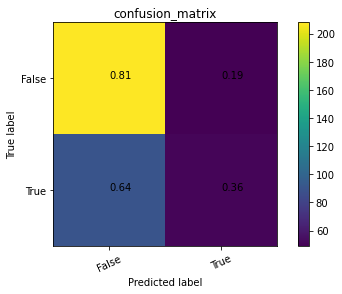

In [288]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_true, y_pred)
cm_class=['False', "True"]
plot_conf_matrix(cm, cm_class, normalize=True)

In [289]:
from sklearn.metrics import classification_report, f1_score, recall_score, precision_score, roc_auc_score, accuracy_score, roc_curve, auc
def evaluation_matrics(y_test, predictions):
  print({'accuracy for False class': accuracy_score(y_test[y_test==False], predictions[y_test==False].reshape(-1))})
  print({'accuracy for True class': accuracy_score(y_test[y_test==True], predictions[y_test==True].reshape(-1))})
  print({'accuracy ': accuracy_score(y_test, predictions.reshape(-1))})
  # precision 
  precision = precision_score(y_test, predictions)
  print('Precision: %f' % precision)
  # recall:
  recall = recall_score(y_test, predictions)
  print('Recall: %f' % recall)
  # f1 scorw:
  f1 = f1_score(y_test, predictions)
  print('F1 score: %f' % f1)

In [290]:
evaluation_matrics(y_true, y_pred)

{'accuracy for False class': 0.8093385214007782}
{'accuracy for True class': 0.3617021276595745}
{'accuracy ': 0.6507537688442211}
Precision: 0.510000
Recall: 0.361702
F1 score: 0.423237


In [291]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.81      0.75       257
           1       0.51      0.36      0.42       141

    accuracy                           0.65       398
   macro avg       0.60      0.59      0.59       398
weighted avg       0.63      0.65      0.63       398

